# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [34]:
#https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import normalize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages = 3 

In [35]:
# Hyperparameters

NOISE = 0.2        # amount of noise to add to exercise
NETWORK = 'ANN'    # or ANN
THRESHOLD = 1      # 1: mean, 2: max, 3: deterministic
threshold_d = 0.05 # threshold for deterministic

In [36]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 


In [37]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'
path_attack = path +'Attack.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  
attack_df = pd.read_csv(path_attack)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

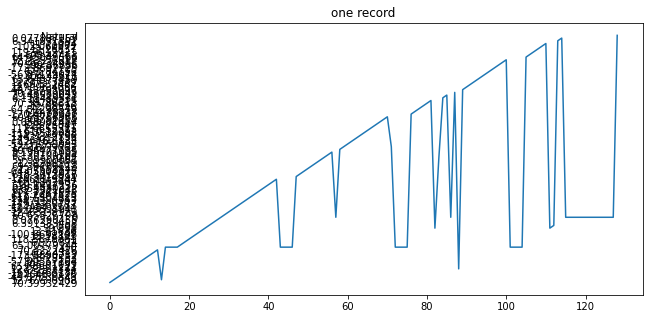

In [38]:
y = traffic_df.iloc[[0]].values.tolist() 
x = list(range(0, len(y[0])))
fig = plt.figure(figsize=(10,5))
plt.plot(x,y[0])
plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = False,
    labelbottom=False)

plt.title('one record')
plt.show()

In [8]:
traffic_df.columns

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)

In [9]:
# Delete marker column 
traffic_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)
attack_df.drop(['marker'], axis=1, inplace=True)

In [10]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('combine shape', combine_np.shape)
attack_np = attack_df.to_numpy()
print('attack shape', attack_np.shape)

normal shape (22714, 128)
combine shape (78377, 128)
attack shape (55663, 128)


In [11]:
# This is how it looks
traffic_np
print(traffic_np.shape)

(22714, 128)


In [12]:
# manage NaNs & inf
print('normal traffic NaNs', np.count_nonzero(np.isnan(traffic_np)))
print('normal traffic inf', np.count_nonzero(np.isinf(traffic_np)))
print('combine traffic NaNs', np.count_nonzero(np.isnan(combine_np)))
print('combine traffic inf', np.count_nonzero(np.isinf(combine_np)))
print('attack traffic NaNs', np.count_nonzero(np.isnan(attack_np)))
print('attack traffic inf', np.count_nonzero(np.isinf(attack_np)))
traffic_np = np.nan_to_num(traffic_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
combine_np = np.nan_to_num(combine_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
attack_np = np.nan_to_num(attack_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# not so sure that inf is correctly set to 0

normal traffic NaNs 0
normal traffic inf 3753
combine traffic NaNs 0
combine traffic inf 10906
attack traffic NaNs 0
attack traffic inf 7153


In [13]:
# normalize the data on each column

traffic_np_norm = normalize(traffic_np, axis=0, norm='max')
combine_np_norm = normalize(combine_np, axis=0, norm='max')
attack_np_norm = normalize(attack_np, axis=0, norm='max')

# alternative normalization
from sklearn.preprocessing import minmax_scale
traffic_np_norm = minmax_scale(traffic_np, feature_range=(0, 1), axis=0, copy=True)
combine_np_norm = minmax_scale(combine_np, feature_range=(0, 1), axis=0, copy=True)
attack_np_norm = minmax_scale(attack_np, feature_range=(0, 1), axis=0, copy=True)

#adding noise to x_train
noise = np.random.normal(0, NOISE, traffic_np_norm.shape)

In [14]:
x_train = traffic_np_norm[...,np.newaxis]
x_combine = combine_np_norm[...,np.newaxis]
x_attack = attack_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", x_train.shape)
print("Combine Traffic Test input shape: ", x_combine.shape)
print("Attack Traffic Test input shape: ", x_attack.shape)

Normal Traffic Training input shape:  (22714, 128, 1)
Combine Traffic Test input shape:  (78377, 128, 1)
Attack Traffic Test input shape:  (55663, 128, 1)


In [15]:
x_train.shape

(22714, 128, 1)

In [16]:
input_dim = x_train.shape[1]
encoding_dim = x_train.shape[1]

def build_model_ANN():
   input_ANN = layers.Input(shape=(input_dim, ))
#   encoder = layers.Dropout(rate=0.2)(input_ANN)
   encoder = layers.Dense(4096, activation='relu')(input_ANN)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(1024, activation='relu')(input_ANN)
   encoder = layers.Dense(512, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(128, activation='relu')(encoder)
   encoder = layers.Dropout(rate=0.2)(encoder)
   encoder = layers.Dense(32, activation='relu')(encoder)
   decoder = layers.Dropout(rate=0.2)(encoder)
   decoder = layers.Dense(128, activation='relu')(decoder)
   decoder = layers.Dropout(rate=0.2)(decoder)
   decoder = layers.Dense(512, activation='tanh')(decoder)
   decoder = layers.Dense(1024, activation='tanh')(decoder)
   decoder = layers.Dense(4096, activation='tanh')(decoder)
   out_layer = layers.Dense(encoding_dim, activation = 'tanh')(decoder)
   autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)
   return autoencoder

def build_model_CNN():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=64, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=256, kernel_size=3, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=512, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

In [19]:
# We arange dimensions to work with CNN or ANN
# Remember CNN has an additional dimension at the end

keras.backend.clear_session()

if NETWORK == 'CNN':
    model = build_model_CNN()
    noise = noise[...,np.newaxis]
elif NETWORK == 'ANN':
    model = build_model_ANN()
    x_train = np.squeeze(x_train)
    x_attack = np.squeeze(x_attack)
    x_combine = np.squeeze(x_combine)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              132096    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128  

In [20]:
noise.shape

(22714, 128)

In [21]:
## Train the model

#Note that we are using `x_train` as both the input and the target
#since this is a reconstruction model.
#"""
x_train_noisy = x_train + noise

history = model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.17,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
148/148 [==============================] - 7s 41ms/step - loss: 0.0251 - val_loss: 0.0106
Epoch 2/50
148/148 [==============================] - 6s 40ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 3/50
148/148 [==============================] - 6s 40ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 4/50
148/148 [==============================] - 6s 40ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 5/50
148/148 [==============================] - 6s 41ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 6/50
148/148 [==============================] - 6s 43ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 7/50
148/148 [==============================] - 6s 43ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 8/50
148/148 [==============================] - 6s 39ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 9/50
148/148 [==============================] - 6s 39ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 10/50
148/148 [==============================] - 6s 39ms/step - loss: 0.0054 - val_lo

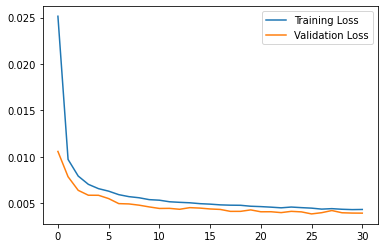

In [22]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [23]:
### Test the results
## use combine_labels as ground truth

# Get test attack loss.
x_attack_pred = model.predict(x_attack)
attack_mae_loss = np.mean(np.abs(x_attack_pred - x_attack), axis=1)
attack_mae_loss = attack_mae_loss.reshape((-1))

# Get test MAE loss.
x_test_pred = model.predict(x_combine)
test_mae_loss = np.mean(np.abs(x_test_pred - x_combine), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)
train_mae_loss = train_mae_loss.reshape((-1))

threshold_calc = np.max(train_mae_loss)
print('calculated threshold',threshold_calc)

# alternative threshold calculation
max = np.max(train_mae_loss)
min = np.min(train_mae_loss)
threshold_alt = (max-min)/2

print('alternative threshold',threshold_alt)

threshold = threshold_calc
threshold = 0.05
threshold = threshold_alt

if THRESHOLD == 1:               # mean
    threshold = threshold_alt
elif THRESHOLD == 2:             # max
    threshold = threshold_calc
elif THRESHOLD == 3:
    threshold = threshold_d

print(' -> using ', threshold)

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


calculated threshold 0.23469581426432506
alternative threshold 0.11332971705717815
 -> using  0.11332971705717815
Number of anomaly samples:  1847
Indices of anomaly samples:  (array([  475,   486,   487, ..., 78011, 78273, 78316]),)


In [24]:
# Some predictions for the figure
pred = model.predict(x_combine)
mae_loss = np.mean(np.abs(pred - x_combine), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': np.squeeze(mae_loss),
                        'True_class': combine_labels})

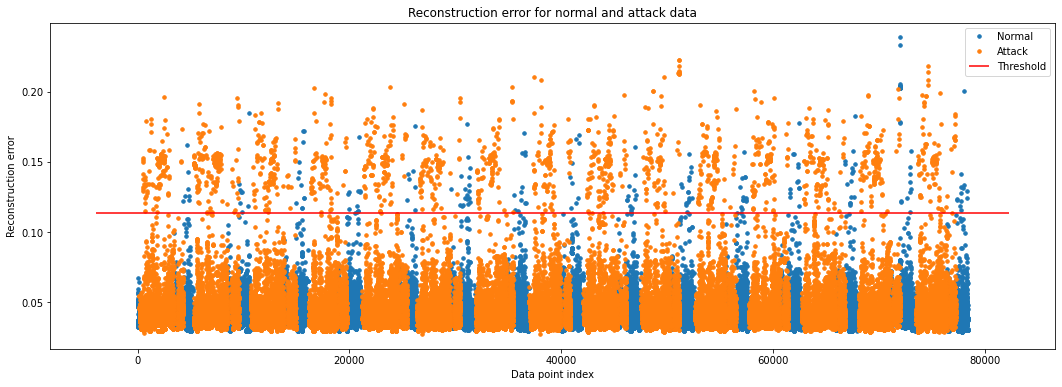

In [25]:
threshold_fixed = threshold
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(18,6))
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Attack" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and attack data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

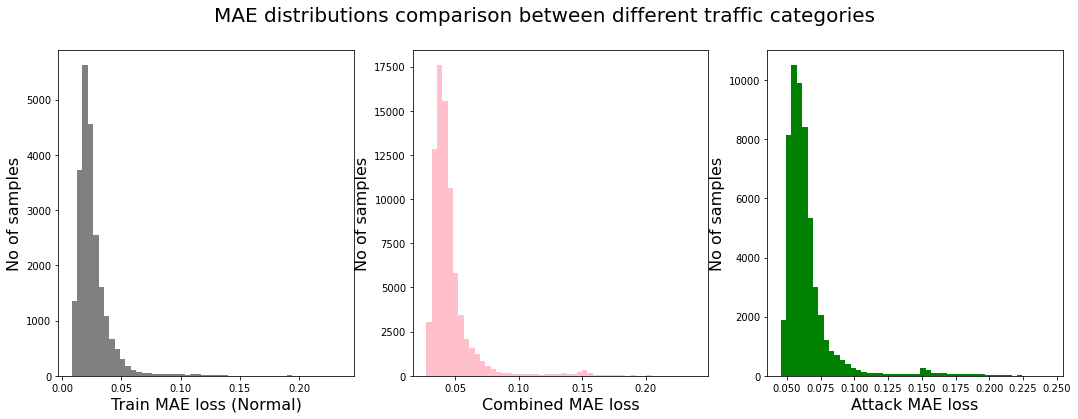

In [26]:
# comparison of MAE distributions (attack, normal and combined)
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('MAE distributions comparison between different traffic categories',size=20)
ax1.hist(train_mae_loss, bins=50, color='grey')
ax1.set_xlabel('Train MAE loss (Normal)', size=16)
ax1.set_ylabel('No of samples', size = 16)
ax2.hist(test_mae_loss, bins=50, color='pink')
ax2.set_xlabel('Combined MAE loss', size = 16)
ax2.set_ylabel('No of samples', size = 16)
ax3.hist(attack_mae_loss, bins=50, color='green')
ax3.set_xlabel('Attack MAE loss', size = 16)
ax3.set_ylabel('No of samples', size = 16)
plt.show()

In [27]:
print("number of attacks", np.sum(combine_labels), 'number of normal ', 
      len(combine_labels) - np.sum(combine_labels))

number of attacks 55663 number of normal  22714


In [28]:
def accuracy_labels(a,b):
    i=0
    n = 0
    p = 0
    fp = 0
    fn = 0
    ac = 0
    for i in range (0,len(a)):
        if (a[i] == False) and(b[i] == 0): # False and 0 is normal traffic right
            n = n + 1
            ac = ac + 1
        elif (a[i] == True) and (b[i]==1): # True (attack) and 1 attack is attack right
            p = p + 1
            ac = ac + 1
        elif (a[i] == False) and (b[i] == 1): # False (normal) and 1 is false negative
            fn = fn + 1
        elif (a[i] == True) and (b[i] == 0): # True (attack) and 0 is false positive
            fp = fp + 1
        else:
            print (a[i], b[i])
    print (i, '-> elements')
    return n, p, fp, fn, ac
            

In [29]:
neg, pos, false_pos, false_neg, accuracy = accuracy_labels(anomalies, combine_labels)

78376 -> elements


In [30]:
print ('accuracy :', accuracy/len(combine_labels))
print ('negatives :', neg)
print ('positives :', pos)
print ('false negatives :', false_neg)
print ('false positives :', false_pos)

accuracy : 0.30829197341056686
negatives : 22515
positives : 1648
false negatives : 54015
false positives : 199


In [31]:
#EOF